In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import pad
import math 

import matplotlib.pyplot as plt

## Summary

Here is a small self-contained implementation of the different parametrizations discussed in the notes.

The classes before are a good starting point for custom extensions:
* Adding modularity and flexibility, for example variable `in_channel`, `out_channel` (matching PyTorch APIs)
* Improving parameter initializations
* Extending with e.g., different classes of $(A, B, C, D)$ for SSMs (from this excellent resource: https://github.com/HazyResearch/state-spaces)

In [2]:
torch.manual_seed(1234)

L = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5
u = torch.sin(freq * x) + 0.5 * torch.randn(L) 
u = u[None, None]

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'

In [3]:
class ExplicitConv1d(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels):
        super().__init__()
        params = torch.randn(out_channels, in_channels, \
             kernel_size) / math.sqrt(in_channels * kernel_size)
        self.params = nn.Parameter(params)

    def forward(self, x):
        return torch.nn.functional.conv1d(x, self.params)

class ExplicitFreqConv1d(nn.Module):
    def __init__(self, modes, in_channels, out_channels):
        super().__init__()
        params = torch.randn(out_channels, in_channels, \
            modes, 2) / math.sqrt(in_channels * modes)
        self.params = nn.Parameter(params)
        
    def forward(self, x):
        L = x.shape[-1]
        X = torch.fft.rfft(x, dim=-1)
        H = self.params[..., 0] + 1j * self.params[..., 1]
        H = pad(H, (0, X.shape[-1] - H.shape[-1]))
        Y = X * H
        y = torch.fft.irfft(Y, dim=-1)
        return y

class ImplicitSSMConv1d(nn.Module):
    def __init__(self, d_state, in_channels, out_channels):
        super().__init__()
        A = torch.diag_embed(torch.clamp(torch.randn(d_state), -0.9, -0.5))
        B = torch.ones(d_state) / d_state
        C = torch.ones(d_state)
        D = torch.ones(1)

        self.A = nn.Parameter(A)
        self.B = nn.Parameter(B)
        self.C = nn.Parameter(C)
        self.D = nn.Parameter(D)

    def kernel(self, L):
        return torch.tensor([self.B@ torch.matrix_power(self.A, k)@self.C for k in range(L)])

    def forward(self, x):
        L = x.shape[-1]
        X = torch.fft.rfft(x, dim=-1)
        h = self.kernel(L)
        H = torch.fft.rfft(h, dim=-1)
        Y = X * H
        y = torch.fft.irfft(Y, dim=-1)
        return y

class ImplicitTFConv1d(nn.Module):
    def __init__(self, order, in_channels, out_channels):
        super().__init__()
        num_poly_coefs = torch.randn(order) 
        den_poly_coefs = torch.randn(order)

        self.num_poly_coefs = nn.Parameter(num_poly_coefs)
        self.den_poly_coefs = nn.Parameter(den_poly_coefs)

    def polyval(self, coefs, z):
        eval = coefs[0] + torch.zeros_like(z)
        for c in coefs[1:]:
            eval += eval * z + c
        return eval

    def freqresp(self, L):
        w = torch.linspace(0, 2*torch.pi, L)
        z = torch.exp(-1j * w) 
        num = self.polyval(self.num_poly_coefs, z)
        den = self.polyval(self.den_poly_coefs, z)
        return num / den

    def forward(self, x):
        L = x.shape[-1]
        X = torch.fft.fft(x, dim=-1)
        H = self.freqresp(L)
        Y = X * H
        y = torch.fft.ifft(Y, dim=-1)
        return y

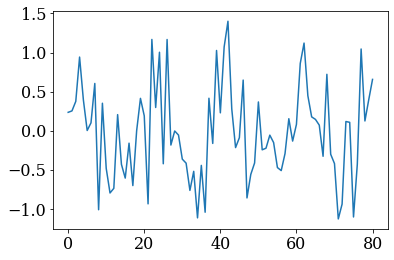

In [4]:
econv = ExplicitConv1d(20, 1, 1)
y_econv = econv(u)
plt.plot(y_econv[0, 0].detach())

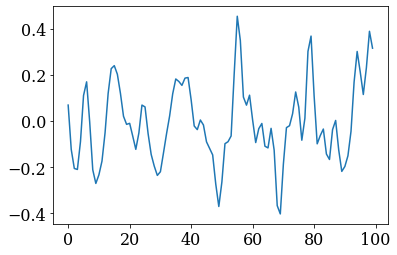

In [5]:
fconv = ExplicitFreqConv1d(30, 1, 1)
y_fconv = fconv(u)
plt.plot(y_fconv[0, 0].detach())

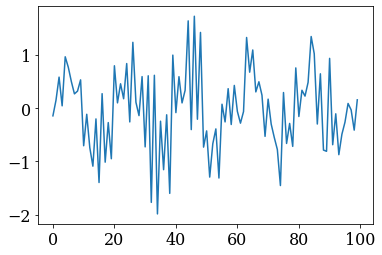

In [6]:
ssmconv = ImplicitSSMConv1d(10, 1, 1)
y_ssmconv = ssmconv(u)
plt.plot(y_ssmconv[0, 0].detach())

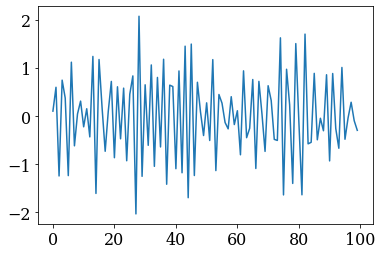

In [7]:
tfconv = ImplicitTFConv1d(10, 1, 1)
y_tfconv = tfconv(u)
plt.plot(y_tfconv[0, 0].real.detach())
